In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import gc
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold,GroupKFold,train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#importing plotly
import chart_studio
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

import os
for dirname, _, filenames in os.path.join(os.getcwd(),os.walk('/input')):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'generator'

In [8]:
os.getcwd()

'/home/sjsouvik/projects/hackerearth_airplanedisaster'

## Reading the given dataset

In [2]:
train_df = pd.read_csv('/input/airplane-accidents-severity-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/test.csv')
sample_sub_df = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/sample_submission.csv')

FileNotFoundError: [Errno 2] File /input/airplane-accidents-severity-dataset/train.csv does not exist: '/input/airplane-accidents-severity-dataset/train.csv'

## Highlights of the dataset

<pre>
Accident_ID:              	unique id assigned to each row
Accident_Type_Code:     	  the type of accident (factor, not numeric)
Cabin_Temperature:      	  the last recorded temperature before the incident, measured in degrees fahrenheit
Turbulence_In_gforces:	    the recorded/estimated turbulence experienced during the accident
Control_Metric:               an estimation of how much control the pilot had during the incident given the factors at play
Total_Safety_Complaints: 	 number of complaints from mechanics prior to the accident
Days_Since_Inspection:  	  how long the plane went without inspection before the incident
Safety_Score:           	  a measure of how safe the plane was deemed to be
Severity:	                 a description (4 level factor) on the severity of the crash [Target]
</pre>

In [127]:
train_df.head()

Severity  Safety_Score  \
0                Minor_Damage_And_Injuries        49.224   
1                Minor_Damage_And_Injuries        62.466   
2        Significant_Damage_And_Fatalities        63.059   
3  Significant_Damage_And_Serious_Injuries        48.082   
4        Significant_Damage_And_Fatalities        26.484   

   Days_Since_Inspection  Total_Safety_Complaints  Control_Metric  \
0                     14                       22          71.285   
1                     10                       27          72.288   
2                     13                       16          66.363   
3                     11                        9          74.704   
4                     13                       25          47.949   

   Turbulence_In_gforces  Cabin_Temperature  Accident_Type_Code  \
0                  0.272             78.040                   2   
1                  0.424             84.540                   2   
2                  0.323             78.860                   7   
3                  0.337             81.790                   3   
4                  0.541             77.160                   3   

   Max_Elevation  Violations  Adverse_Weather_Metric  Accident_ID  
0      31335.477           3                   0.424         7570  
1      26024.711           2                   0.352        12128  
2      39269.054           3                   0.003         2181  
3      42771.499           1                   0.212         5946  
4      35509.229           2                   0.177         9054

In [128]:
test_df.head()

Safety_Score  Days_Since_Inspection  Total_Safety_Complaints  \
0        19.498                     16                        6   
1        58.174                     15                        3   
2        33.288                     15                        3   
3         3.288                     21                        5   
4        10.868                     18                        2   

   Control_Metric  Turbulence_In_gforces  Cabin_Temperature  \
0          72.151                  0.389             78.320   
1          64.585                  0.251             78.600   
2          64.722                  0.337             86.960   
3          66.363                  0.422             80.860   
4          56.108                  0.313             79.220   

   Accident_Type_Code  Max_Elevation  Violations  Adverse_Weather_Metric  \
0                   4      37949.724           2                   0.070   
1                   7      30194.806           2                   0.003   
2                   6      17572.925           1                   0.004   
3                   3      40209.186           2                   0.200   
4                   2      35495.525           2                   0.484   

   Accident_ID  
0            1  
1           10  
2           14  
3           17  
4           21

In [129]:
sample_sub_df.head()

Accident_ID                                 Severity
0            1                Minor_Damage_And_Injuries
1           10                Highly_Fatal_And_Damaging
2           14                Highly_Fatal_And_Damaging
3           17  Significant_Damage_And_Serious_Injuries
4           21                Minor_Damage_And_Injuries

In [130]:
print(f'Shape of training data: {train_df.shape}')
print(f'Shape of testing data: {test_df.shape}')

Shape of training data: (10000, 12)
Shape of testing data: (2500, 11)


## Analysis of missing values (NaNs)

In [131]:
train_df.isna().sum()

Severity                   0
Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

In [132]:
(train_df==0).sum()

Severity                      0
Safety_Score                  5
Days_Since_Inspection         0
Total_Safety_Complaints    1281
Control_Metric                3
Turbulence_In_gforces         0
Cabin_Temperature             0
Accident_Type_Code            0
Max_Elevation                 0
Violations                  696
Adverse_Weather_Metric        0
Accident_ID                   0
dtype: int64

In [133]:
test_df.isna().sum()

Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

In [134]:
(test_df==0).sum()

Safety_Score                 3
Days_Since_Inspection        0
Total_Safety_Complaints    326
Control_Metric               0
Turbulence_In_gforces        0
Cabin_Temperature            0
Accident_Type_Code           0
Max_Elevation                0
Violations                 162
Adverse_Weather_Metric       0
Accident_ID                  0
dtype: int64

So there are no missing values in the dataset.

## Exploratory Data Analysis

In [135]:
X_train = train_df.drop(['Severity', 'Accident_ID'], axis=1)
Y_train = train_df['Severity']

In [136]:
Y_train.unique()

array(['Minor_Damage_And_Injuries', 'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries',
       'Highly_Fatal_And_Damaging'], dtype=object)

So there are 4 classes of accidents (out target variable). Let's map those classes to integers

In [137]:
Y_train = Y_train.map(class_map).astype(np.uint8)

In [138]:
train_df.head()

Severity  Safety_Score  \
0                Minor_Damage_And_Injuries        49.224   
1                Minor_Damage_And_Injuries        62.466   
2        Significant_Damage_And_Fatalities        63.059   
3  Significant_Damage_And_Serious_Injuries        48.082   
4        Significant_Damage_And_Fatalities        26.484   

   Days_Since_Inspection  Total_Safety_Complaints  Control_Metric  \
0                     14                       22          71.285   
1                     10                       27          72.288   
2                     13                       16          66.363   
3                     11                        9          74.704   
4                     13                       25          47.949   

   Turbulence_In_gforces  Cabin_Temperature  Accident_Type_Code  \
0                  0.272             78.040                   2   
1                  0.424             84.540                   2   
2                  0.323             78.860                   7   
3                  0.337             81.790                   3   
4                  0.541             77.160                   3   

   Max_Elevation  Violations  Adverse_Weather_Metric  Accident_ID  
0      31335.477           3                   0.424         7570  
1      26024.711           2                   0.352        12128  
2      39269.054           3                   0.003         2181  
3      42771.499           1                   0.212         5946  
4      35509.229           2                   0.177         9054

In [139]:
safetysummary=train_df.groupby('Severity')[['Safety_Score','Control_Metric','Adverse_Weather_Metric','Max_Elevation','Violations','Cabin_Temperature','Turbulence_In_gforces','Total_Safety_Complaints','Days_Since_Inspection']].mean()


lists=[]
for idx,i in enumerate(safetysummary.columns):
    bool_array=[False]*len(safetysummary.columns)
    bool_array[idx]=True
    lists.append(
        dict(label=str(i),
             method="update",
             args=[{"visible":bool_array},
                   {"title":i}]))

layout=dict(
    updatemenus=list([
        dict(
            active=0,
            buttons=lists,
        )
    ])
)

safetysummary.iplot(kind='bar', xTitle='Severity', yTitle='Magnitude',title='Severity to mean scores',layout=layout)

### 1. Distribution of Target Variable 

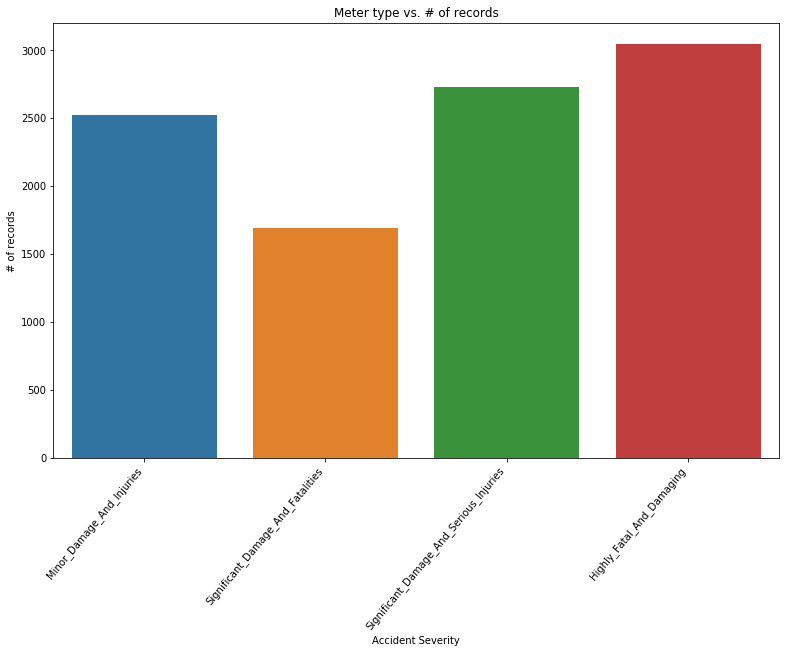

In [140]:
plt.figure(figsize=(13,8))
ax = sns.barplot(np.vectorize(inverse_class_map.get)(pd.unique(Y_train)), Y_train.value_counts().sort_index())
ax.set(xlabel='Accident Severity', ylabel='# of records', title='Meter type vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### 2. Distribution of safety score

In [141]:
train_df.head()

Severity  Safety_Score  \
0                Minor_Damage_And_Injuries        49.224   
1                Minor_Damage_And_Injuries        62.466   
2        Significant_Damage_And_Fatalities        63.059   
3  Significant_Damage_And_Serious_Injuries        48.082   
4        Significant_Damage_And_Fatalities        26.484   

   Days_Since_Inspection  Total_Safety_Complaints  Control_Metric  \
0                     14                       22          71.285   
1                     10                       27          72.288   
2                     13                       16          66.363   
3                     11                        9          74.704   
4                     13                       25          47.949   

   Turbulence_In_gforces  Cabin_Temperature  Accident_Type_Code  \
0                  0.272             78.040                   2   
1                  0.424             84.540                   2   
2                  0.323             78.860                   7   
3                  0.337             81.790                   3   
4                  0.541             77.160                   3   

   Max_Elevation  Violations  Adverse_Weather_Metric  Accident_ID  
0      31335.477           3                   0.424         7570  
1      26024.711           2                   0.352        12128  
2      39269.054           3                   0.003         2181  
3      42771.499           1                   0.212         5946  
4      35509.229           2                   0.177         9054

In [142]:
#correlation b/w safety scores and days since inspection
import plotly.graph_objects as go
from cufflinks import tools
import chart_studio.plotly as py
safetysummary1=train_df.groupby('Days_Since_Inspection')[['Safety_Score']].mean()
safetysummary1.iplot(kind='bar', xTitle='Days_Since_Inspection',fill=True, yTitle='Magnitude',title='Severity to mean scores')


So,as seen we have a high degree of correlation between them

### 3. Distribution of days till Last inspection

In [143]:
train_data=X_train[['Safety_Score','Control_Metric','Adverse_Weather_Metric','Max_Elevation','Cabin_Temperature','Turbulence_In_gforces','Total_Safety_Complaints','Days_Since_Inspection']]

lists=[]
for idx,i in enumerate(train_data.columns):
    bool_array=[False]*len(train_data.columns)
    bool_array[idx]=True
    lists.append(
        dict(label=str(i)+" histogram",
             method="update",
             args=[{"visible":bool_array},
                   {"title":i}]))

layout=dict(
    updatemenus=list([
        dict(
            active=0,
            buttons=lists,
        )
    ])
)

#X_train[['Safety_Score','Control_Metric','Adverse_Weather_Metric']].iplot(kind="hist",title="ass",layout=layout)
train_df[['Safety_Score','Control_Metric','Adverse_Weather_Metric','Max_Elevation','Cabin_Temperature','Turbulence_In_gforces','Total_Safety_Complaints','Days_Since_Inspection']].iplot(kind="hist",title="ass",layout=layout)

In [144]:
num_columns=[i for i in train_df.columns if train_df[i].dtype in [np.int64,np.float64]]
train_df[num_columns].corr()

Safety_Score  Days_Since_Inspection  \
Safety_Score                    1.000                 -0.685   
Days_Since_Inspection          -0.685                  1.000   
Total_Safety_Complaints         0.058                 -0.032   
Control_Metric                  0.001                 -0.012   
Turbulence_In_gforces           0.020                 -0.002   
Cabin_Temperature               0.033                 -0.039   
Accident_Type_Code              0.174                 -0.025   
Max_Elevation                   0.004                  0.000   
Violations                      0.042                 -0.017   
Adverse_Weather_Metric         -0.108                  0.041   
Accident_ID                    -0.001                  0.001   

                         Total_Safety_Complaints  Control_Metric  \
Safety_Score                               0.058           0.001   
Days_Since_Inspection                     -0.032          -0.012   
Total_Safety_Complaints                    1.000          -0.020   
Control_Metric                            -0.020           1.000   
Turbulence_In_gforces                      0.066          -0.643   
Cabin_Temperature                          0.014          -0.008   
Accident_Type_Code                         0.035           0.008   
Max_Elevation                              0.037          -0.028   
Violations                                -0.019          -0.003   
Adverse_Weather_Metric                    -0.003          -0.028   
Accident_ID                                0.005           0.006   

                         Turbulence_In_gforces  Cabin_Temperature  \
Safety_Score                             0.020              0.033   
Days_Since_Inspection                   -0.002             -0.039   
Total_Safety_Complaints                  0.066              0.014   
Control_Metric                          -0.643             -0.008   
Turbulence_In_gforces                    1.000              0.011   
Cabin_Temperature                        0.011              1.000   
Accident_Type_Code                      -0.008              0.031   
Max_Elevation                            0.048             -0.009   
Violations                               0.013              0.019   
Adverse_Weather_Metric                   0.040             -0.027   
Accident_ID                             -0.014              0.015   

                         Accident_Type_Code  Max_Elevation  Violations  \
Safety_Score                          0.174          0.004       0.042   
Days_Since_Inspection                -0.025          0.000      -0.017   
Total_Safety_Complaints               0.035          0.037      -0.019   
Control_Metric                        0.008         -0.028      -0.003   
Turbulence_In_gforces                -0.008          0.048       0.013   
Cabin_Temperature                     0.031         -0.009       0.019   
Accident_Type_Code                    1.000          0.020       0.046   
Max_Elevation                         0.020          1.000      -0.031   
Violations                            0.046         -0.031       1.000   
Adverse_Weather_Metric               -0.739          0.173      -0.022   
Accident_ID                          -0.012          0.009      -0.002   

                         Adverse_Weather_Metric  Accident_ID  
Safety_Score                             -0.108       -0.001  
Days_Since_Inspection                     0.041        0.001  
Total_Safety_Complaints                  -0.003        0.005  
Control_Metric                           -0.028        0.006  
Turbulence_In_gforces                     0.040       -0.014  
Cabin_Temperature                        -0.027        0.015  
Accident_Type_Code                       -0.739       -0.012  
Max_Elevation                             0.173        0.009  
Violations                               -0.022       -0.002  
Adverse_Weather_Metric                    1.000        0.009  
Accident_ID                 

In [145]:
#train_df['Days_Since_Inspection'].hist(by=train_df['Severity']);
box_age = train_df[['Safety_Score', 'Severity']]
box_age.pivot(columns='Severity', values='Safety_Score').iplot(kind='box')

### 3. Total safety complaints[](http://)

In [146]:
#outlier processing clipping to 99th percentile
percentiles = train_df['Total_Safety_Complaints'].quantile([0.01,0.99]).values
train_df['Total_Safety_Complaints'] = np.clip(train_df['Total_Safety_Complaints'], percentiles[0], percentiles[1])

In [147]:
#train_df['Days_Since_Inspection'].hist(by=train_df['Severity']);
box_age = train_df[['Total_Safety_Complaints', 'Severity']]
box_age.pivot(columns='Severity', values='Total_Safety_Complaints').iplot(kind='box')

### 4. Distribution of control metric

We see that there is significant correlation between turbulence and Control Metric

In [148]:
train_df.columns

Index(['Severity', 'Safety_Score', 'Days_Since_Inspection',
       'Total_Safety_Complaints', 'Control_Metric', 'Turbulence_In_gforces',
       'Cabin_Temperature', 'Accident_Type_Code', 'Max_Elevation',
       'Violations', 'Adverse_Weather_Metric', 'Accident_ID'],
      dtype='object')

In [149]:
train_df[['Turbulence_In_gforces','Control_Metric']].corr()
#train_df[['Turbulence_In_gforces','Control_Metric']].iplot(kind='scatter', xTitle='Control_Metric', yTitle='Turbulence_In_gforces',title='Turbulence to Control')

Turbulence_In_gforces  Control_Metric
Turbulence_In_gforces                  1.000          -0.643
Control_Metric                        -0.643           1.000

In [150]:
def plot_after_outlier_removal(train_df):
    train_df2=train_df.copy()
    percentiles1 = train_df2['Control_Metric'].quantile([0.01,0.99]).values
    train_df2['Control_Metric'] = np.clip(train_df2['Control_Metric'], percentiles1[0], percentiles1[1])
    percentiles2 = train_df2['Turbulence_In_gforces'].quantile([0.01,0.99]).values
    train_df2['Turbulence_In_gforces'] = np.clip(train_df2['Turbulence_In_gforces'], percentiles2[0], percentiles2[1])
    train_df2[['Turbulence_In_gforces','Control_Metric']].iplot(kind='scatter',mode='markers', x='Control_Metric', y='Turbulence_In_gforces',title='Turbulence to Control')
plot_after_outlier_removal(train_df)    

#train_df.iplot(kind='scatter',mode='markers', x='Control_Metric', y='Turbulence_In_gforces',title='Turbulence to Control', filename='cufflinks/simple-scatter')

## Accident Type Code Exploration

In [151]:
codesummary

Safety_Score  Control_Metric  Adverse_Weather_Metric  \
Accident_Type_Code                                                         
1                         34.473          64.627                   1.147   
2                         47.373          65.059                   0.440   
3                         40.507          65.134                   0.157   
4                         34.164          65.356                   0.059   
5                         47.265          64.598                   0.022   
6                         40.748          66.885                   0.008   
7                         53.226          64.080                   0.003   

                    Max_Elevation  Cabin_Temperature  Turbulence_In_gforces  \
Accident_Type_Code                                                            
1                       31170.197             79.774                  0.390   
2                       32584.337             79.948                  0.380   
3                       31464.476             79.937                  0.384   
4                       32091.313             79.966                  0.373   
5                       32221.275             79.967                  0.393   
6                       31946.131             80.135                  0.371   
7                       32466.882             80.072                  0.389   

                    Total_Safety_Complaints  Days_Since_Inspection  Violations  
Accident_Type_Code                                                              
1                                     6.422                 13.449       1.990  
2                                     6.663                 12.778       1.963  
3                                     6.286                 12.901       1.968  
4                                     5.758                 12.957       2.012  
5                                     6.690                 12.450       1.999  
6                                     6.988                 13.058       2.026  
7                                     7.357                 12.827       2.158

In [152]:
codesummary=train_df.groupby('Accident_Type_Code')[['Severity','Safety_Score','Control_Metric','Adverse_Weather_Metric','Max_Elevation','Cabin_Temperature','Turbulence_In_gforces','Total_Safety_Complaints','Days_Since_Inspection','Violations']].mean()


lists=[]
for idx,i in enumerate(codesummary.columns):
    bool_array=[False]*len(codesummary.columns)
    bool_array[idx]=True
    lists.append(
        dict(label=str(i),
             method="update",
             args=[{"visible":bool_array},
                   {"title":i}]))

layout=dict(
    updatemenus=list([
        dict(
            active=0,
            buttons=lists,
        )
    ])
)

codesummary.iplot(kind='bar', xTitle='Accident Type Code', yTitle='Magnitude',title='Accident type code exploration',layout=layout)

### 7. Distribution of Max Elevation

In [153]:
train_df.columns

Index(['Severity', 'Safety_Score', 'Days_Since_Inspection',
       'Total_Safety_Complaints', 'Control_Metric', 'Turbulence_In_gforces',
       'Cabin_Temperature', 'Accident_Type_Code', 'Max_Elevation',
       'Violations', 'Adverse_Weather_Metric', 'Accident_ID'],
      dtype='object')

In [154]:
train_df.head()

Severity  Safety_Score  \
0                Minor_Damage_And_Injuries        49.224   
1                Minor_Damage_And_Injuries        62.466   
2        Significant_Damage_And_Fatalities        63.059   
3  Significant_Damage_And_Serious_Injuries        48.082   
4        Significant_Damage_And_Fatalities        26.484   

   Days_Since_Inspection  Total_Safety_Complaints  Control_Metric  \
0                     14                       22          71.285   
1                     10                       27          72.288   
2                     13                       16          66.363   
3                     11                        9          74.704   
4                     13                       25          47.949   

   Turbulence_In_gforces  Cabin_Temperature  Accident_Type_Code  \
0                  0.272             78.040                   2   
1                  0.424             84.540                   2   
2                  0.323             78.860                   7   
3                  0.337             81.790                   3   
4                  0.541             77.160                   3   

   Max_Elevation  Violations  Adverse_Weather_Metric  Accident_ID  
0      31335.477           3                   0.424         7570  
1      26024.711           2                   0.352        12128  
2      39269.054           3                   0.003         2181  
3      42771.499           1                   0.212         5946  
4      35509.229           2                   0.177         9054

### 8. Distribution of number of violations

In [155]:
pd.crosstab(train_df['Violations'],train_df['Severity'],normalize='index')

Severity    Highly_Fatal_And_Damaging  Minor_Damage_And_Injuries  \
Violations                                                         
0                               0.329                      0.243   
1                               0.308                      0.275   
2                               0.317                      0.246   
3                               0.287                      0.250   
4                               0.271                      0.237   
5                               0.194                      0.194   

Severity    Significant_Damage_And_Fatalities  \
Violations                                      
0                                       0.131   
1                                       0.151   
2                                       0.159   
3                                       0.193   
4                                       0.231   
5                                       0.387   

Severity    Significant_Damage_And_Serious_Injuries  
Violations                                           
0                                             0.297  
1                                             0.266  
2                                             0.278  
3                                             0.269  
4                                             0.261  
5                                             0.226

### 9. Distribution of adverse weather metric

In [156]:
# X_train['Total_Safety_Complaints'] = np.power(2, X_train['Total_Safety_Complaints'])
# X_train['Days_Since_Inspection'] = np.power(2, X_train['Days_Since_Inspection'])
# X_train['Safety_Score'] = np.power(2, X_train['Safety_Score'])

* ## Feature Generation

In [157]:
def flag_features(train_df):
    train_df['Violations_FLAG']=np.where(train_df['Violations']>0,1,0)
    train_df['Total_Safety_Complaints_FLAG']=np.where(train_df['Total_Safety_Complaints']>0,1,0)
    return train_df
train_df=flag_features(train_df)
test_df=flag_features(test_df)

In [158]:
train_df.head()

Severity  Safety_Score  \
0                Minor_Damage_And_Injuries        49.224   
1                Minor_Damage_And_Injuries        62.466   
2        Significant_Damage_And_Fatalities        63.059   
3  Significant_Damage_And_Serious_Injuries        48.082   
4        Significant_Damage_And_Fatalities        26.484   

   Days_Since_Inspection  Total_Safety_Complaints  Control_Metric  \
0                     14                       22          71.285   
1                     10                       27          72.288   
2                     13                       16          66.363   
3                     11                        9          74.704   
4                     13                       25          47.949   

   Turbulence_In_gforces  Cabin_Temperature  Accident_Type_Code  \
0                  0.272             78.040                   2   
1                  0.424             84.540                   2   
2                  0.323             78.860                   7   
3                  0.337             81.790                   3   
4                  0.541             77.160                   3   

   Max_Elevation  Violations  Adverse_Weather_Metric  Accident_ID  \
0      31335.477           3                   0.424         7570   
1      26024.711           2                   0.352        12128   
2      39269.054           3                   0.003         2181   
3      42771.499           1                   0.212         5946   
4      35509.229           2                   0.177         9054   

   Violations_FLAG  Total_Safety_Complaints_FLAG  
0                1                             1  
1                1                             1  
2                1                             1  
3                1                             1  
4                1                             1

# Model 1 with KFOLD

In [159]:
class_map = {
    'Minor_Damage_And_Injuries': 0,
    'Significant_Damage_And_Fatalities': 1,
    'Significant_Damage_And_Serious_Injuries': 2,
    'Highly_Fatal_And_Damaging': 3
}
inverse_class_map = {
    0: 'Minor_Damage_And_Injuries',
    1: 'Significant_Damage_And_Fatalities',
    2: 'Significant_Damage_And_Serious_Injuries',
    3: 'Highly_Fatal_And_Damaging'
}

In [166]:
X=train_df.drop(['Severity'],axis=1)
y=train_df['Severity'].map(class_map)


rf=RandomForestClassifier(random_state=123)
n_splits = 5

kf=StratifiedKFold(n_splits=5,random_state=123)


train_oof = np.zeros((train_df.shape[0],))
test_preds = 0


for i,(train_index,test_index) in enumerate(kf.split(X,y)):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    print("Fold F1Score:", f1_score(y_test, y_pred,average='weighted'))
    test_preds += rf.predict(test_df)/n_splits
    del X_train, X_test, y_train, y_test
    gc.collect()

TRAIN: [1806 1812 1817 ... 9997 9998 9999] TEST: [   0    1    2 ... 2100 2103 2105]


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Fold F1Score: 0.8636361173143255
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [1806 1812 1817 ... 4079 4084 4086]
Fold F1Score: 0.8751062791947325
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [3893 3895 3904 ... 6193 6204 6209]
Fold F1Score: 0.8693658641077889
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [5844 5845 5846 ... 8148 8150 8159]
Fold F1Score: 0.8571931526091925
TRAIN: [   0    1    2 ... 8148 8150 8159] TEST: [7933 7937 7946 ... 9997 9998 9999]
Fold F1Score: 0.8759065802404171


In [189]:
test_preds2=np.round(test_preds).astype(int)
submission_file=pd.DataFrame(test_df['Accident_ID'])
submission_file['Severity']=test_preds2
submission_file['Severity']=submission_file['Severity'].map(inverse_class_map)

In [ ]:
submission.to_csv('submission1.csv', index=False)

In [163]:
# X=train_df.drop(['Severity'],axis=1)
# y=train_df['Severity'].map(class_map)


# rf=RandomForestClassifier(random_state=123)
# X_tr,X_te,y_tr,y_te=train_test_split(X,y,random_state=123)
# rf.fit(X_tr,y_tr)
# y_pred=rf.predict(X_te)
# f1_score(y_pred,y_te,average='weighted')

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.8471919007213461

In [ ]:
# test_df['Total_Safety_Complaints'] = np.power(2, test_df['Total_Safety_Complaints'])
# test_df['Days_Since_Inspection'] = np.power(2, test_df['Days_Since_Inspection'])
# test_df['Safety_Score'] = np.power(2, test_df['Safety_Score'])

In [ ]:
submission = pd.DataFrame([test_df['Accident_ID'], np.vectorize(inverse_class_map.get)(preds)], index=['Accident_ID', 'Severity']).T
submission.to_csv('submission.csv', index=False)
submission.head()

In [ ]:
from IPython.display import FileLink, FileLinks

FileLink('submission.csv')

In [ ]:
import pandas as pd
import cufflinks as cf
cf.go_offline()

roles = 'ABCDE'
prios = ['Medium', 'Low', 'High', 'Low', 'High']
years = [2015, 2014, 2014, 2015, 2014]
avgs = [34.4, 33.55, 3, 12, 15]
total_hours = [34, 123, 4566, 3666, 4000]

data = dict()
data['Prio'] = prios
data['Year'] = years
data['average'] = avgs
data['hours'] = total_hours

df = pd.DataFrame(data)
df.index = list(roles)
df.index.names = ['Role']

In [ ]:
df.head()

In [ ]:
buttons

In [ ]:
layout

In [ ]:
layout['updatemenus']